# Walmart Weekly Sales Forecasting  
## Notebook 1: Data Cleaning and Exploratory Data Analysis (EDA)

**Objective:** Prepare the Walmart sales dataset and explore patterns in weekly sales (seasonality, holidays, and external factors).  
**Output:** A cleaned, feature-engineered dataset saved as `walmart_prepared.csv` for downstream modeling.


In [1]:
# Configuration: update DATA_DIR if your CSV files are stored elsewhere
import os
DATA_DIR = os.getenv("WALMART_DATA_DIR", "/content/sample_data")  # expects train.csv, features.csv, stores.csv




In [2]:
#1.Imports and Setup

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Plot settings
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

# Make sure we see all columns when needed
pd.set_option("display.max_columns", None)


In [3]:
#2.Data Loading

sales_df = pd.read_csv(f"{DATA_DIR}/train.csv")
features_df = pd.read_csv(f"{DATA_DIR}/features.csv")
stores_df = pd.read_csv(f"{DATA_DIR}/stores.csv")

print("Sales shape:", sales_df.shape)
print("Features shape:", features_df.shape)
print("Stores shape:", stores_df.shape)

sales_df.head()

Sales shape: (241338, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


/tmp/ipython-input-2620855701.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv(f"{DATA_DIR}/train.csv")


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
# Basic info
print("=== Sales ===")
sales_df.info()
print("\n=== Features ===")
features_df.info()
print("\n=== Stores ===")
stores_df.info()

# Quick numeric summary
sales_df.describe().T.head()


=== Sales ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241338 entries, 0 to 241337
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         241338 non-null  int64  
 1   Dept          241338 non-null  int64  
 2   Date          241338 non-null  object 
 3   Weekly_Sales  241338 non-null  float64
 4   IsHoliday     241338 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 9.2+ MB

=== Features ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   fl

,count,mean,std,min,25%,50%,75%,max
Store,241338.0,12.755298,7.066384,1.0,7.0000,13.00,19.0000,25.00
Dept,241338.0,43.184438,29.728050,1.0,19.0000,36.00,71.0000,99.00
Weekly_Sales,241338.0,17602.840792,24483.998174,-1699.0,2817.9175,8612.85,22120.6625,693099.36


In [5]:
#3.Data Preparation and Merging

# Ensure Date is datetime in both frames
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
features_df["Date"] = pd.to_datetime(features_df["Date"])

# Merge sales + features
sales_feat = pd.merge(
    sales_df,
    features_df,
    on=["Store", "Date", "IsHoliday"],
    how="left"
)

# Merge with stores
full_df = pd.merge(
    sales_feat,
    stores_df,
    on="Store",
    how="left"
)

full_df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [6]:
print("Full merged shape:", full_df.shape)

# Check for duplicates
dup_count = full_df.duplicated(subset=["Store", "Dept", "Date"]).sum()
print("Number of duplicate Store-Dept-Date rows:", dup_count)


Full merged shape: (241338, 16)
Number of duplicate Store-Dept-Date rows: 0


In [7]:
#If dup_count > 0, then Drop
if dup_count > 0:
    full_df = full_df.drop_duplicates(subset=["Store", "Dept", "Date"])


## 4. Data Cleaning

- Inspect missing values.
- Impute missing MarkDown values (assumed as no promotion when missing).
- Impute CPI and Unemployment with their median.
- Confirm basic data quality.

In [8]:
#4.Data Cleaning
# Count missing values per column
missing_counts = full_df.isna().sum().sort_values(ascending=False)
missing_counts.head(15)


,0
MarkDown2,204302
MarkDown3,197279
MarkDown4,195081
MarkDown1,194411
MarkDown5,194411
Temperature,110266
Fuel_Price,110266
CPI,110266
Unemployment,110266
IsHoliday,0


In [9]:
# 1. Fill MarkDown columns with 0 (no markdown)
markdown_cols = [c for c in full_df.columns if "MarkDown" in c]
print("Markdown columns:", markdown_cols)

full_df[markdown_cols] = full_df[markdown_cols].fillna(0)

# 2. Fill CPI & Unemployment with median values
for col in ["CPI", "Unemployment"]:
    if col in full_df.columns:
        full_df[col] = full_df[col].fillna(full_df[col].median())


Markdown columns: ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']


**Data Cleaning Summary:**

- MarkDown columns contained many missing values; these were treated as no promotion and set to 0.
- CPI and Unemployment had occasional missing values, which were imputed using median values.
- No duplicated Store–Dept–Date entries remained after cleaning.
- All dates were converted to proper datetime format for time-based analysis.

## 5.Feature Engineering

To capture seasonality and store characteristics, I created:

- Time-based features: `Year`, `Month`, `WeekOfYear`
- Categorical encoding: numeric `IsHoliday`, one-hot encoded `Type`
- Lag feature: previous week's sales per Store–Dept (`Lag_1_Week`)


In [11]:
# Sort for lag calculations
full_df = full_df.sort_values(["Store", "Dept", "Date"])

# Drop rows with missing dates, as they cause issues with time-based feature engineering
full_df.dropna(subset=["Date"], inplace=True)

# Time-based features
full_df["Year"] = full_df["Date"].dt.year
full_df["Month"] = full_df["Date"].dt.month
full_df["WeekOfYear"] = full_df["Date"].dt.isocalendar().week.astype(int)

# Encode IsHoliday as int
# Fix: Convert 'IsHoliday' column to a consistent boolean type first
# Handle both actual booleans and string representations ('True', 'False', 'TRUE', 'FALSE')
full_df['IsHoliday'] = full_df['IsHoliday'].apply(lambda x: True if str(x).lower() == 'true' else False)
full_df["IsHoliday"] = full_df["IsHoliday"].astype(int)

# Lag feature: previous week's sales per Store–Dept
full_df["Lag_1_Week"] = full_df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
full_df["Lag_1_Week"] = full_df["Lag_1_Week"].fillna(0)

# One-hot encode store Type (A/B/C)
if "Type" in full_df.columns:
    full_df = pd.get_dummies(full_df, columns=["Type"], drop_first=True)

full_df[["Store", "Dept", "Date", "Weekly_Sales", "Lag_1_Week", "Year", "Month", "WeekOfYear"]].head()

,Store,Dept,Date,Weekly_Sales,Lag_1_Week,Year,Month,WeekOfYear
0,1,1,2010-02-05,24924.50,0.00,2010,2,5
1,1,1,2010-02-12,46039.49,24924.50,2010,2,6
2,1,1,2010-02-19,41595.55,46039.49,2010,2,7
3,1,1,2010-02-26,19403.54,41595.55,2010,2,8
4,1,1,2010-03-05,21827.90,19403.54,2010,3,9


## 6.Exploratory Data Analysis (EDA)

### Distribution of Weekly Sales

First, I examine the overall distribution of `Weekly_Sales` to understand scale, spread, and outliers.


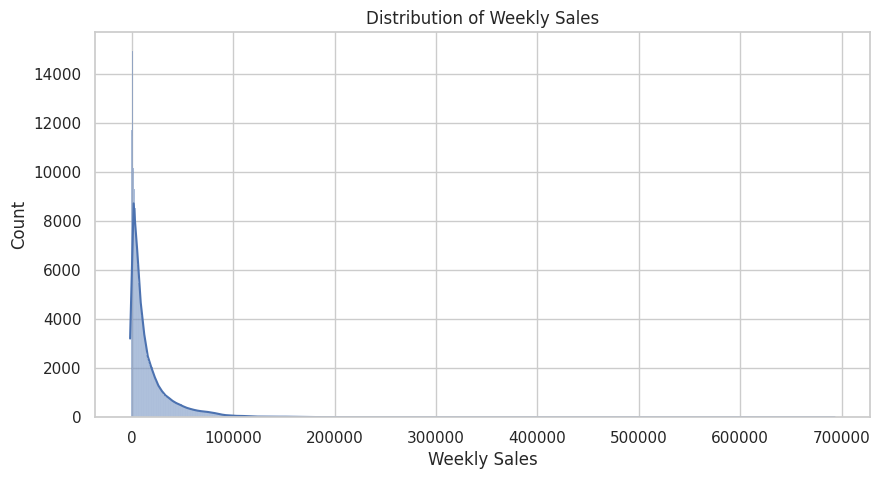

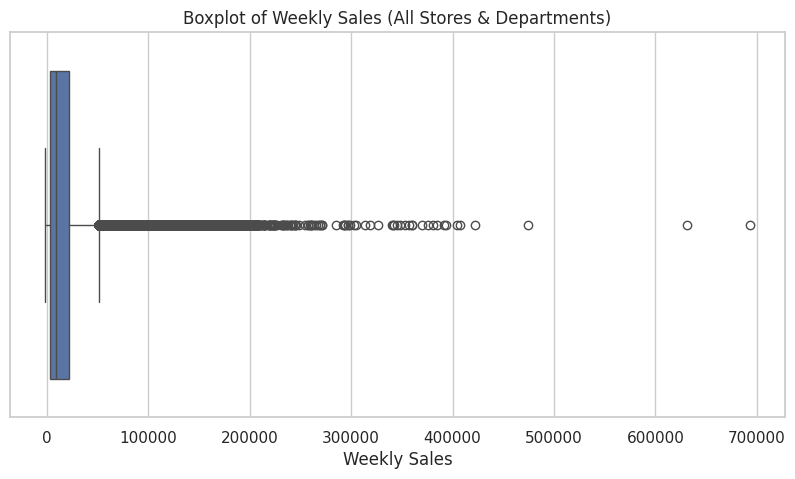

In [13]:
sns.histplot(full_df["Weekly_Sales"], kde=True)
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Count")
plt.show()

sns.boxplot(x=full_df["Weekly_Sales"])
plt.title("Boxplot of Weekly Sales (All Stores & Departments)")
plt.xlabel("Weekly Sales")
plt.show()


### Time Series Example (Single Store & Department)

To visualize seasonality and trend more clearly, I plot weekly sales for a single Store–Department combination.


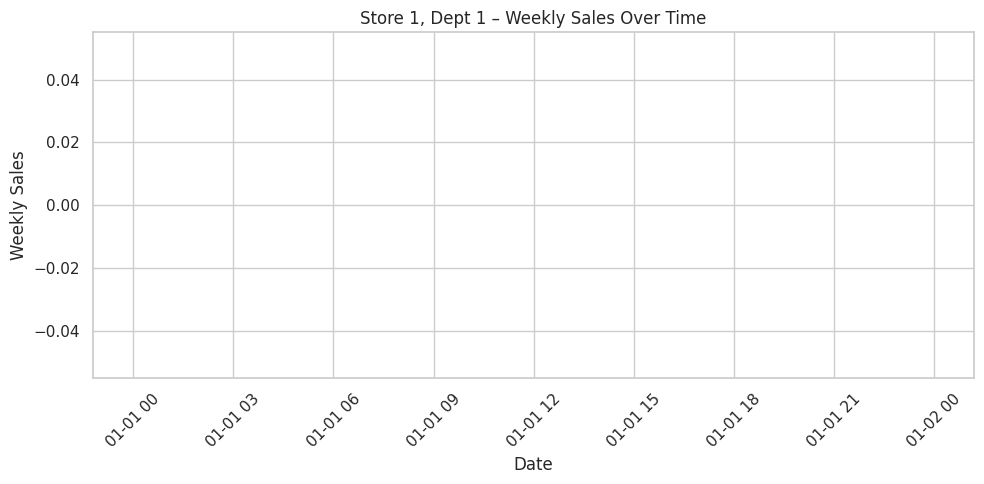

In [ ]:
# one example of store & department
example = full_df[(full_df["Store"] == 1) & (full_df["Dept"] == 1)]

plt.plot(example["Date"], example["Weekly_Sales"])
plt.title("Store 1, Dept 1 – Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 6.3 Holiday vs Non-Holiday Sales

I compare weekly sales between holiday weeks and non-holiday weeks to measure the holiday effect.


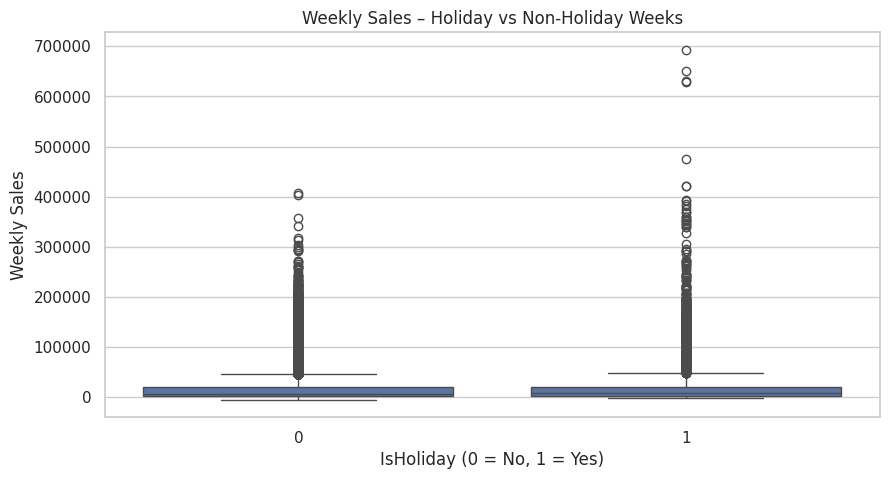

In [ ]:
sns.boxplot(x="IsHoliday", y="Weekly_Sales", data=full_df)
plt.title("Weekly Sales – Holiday vs Non-Holiday Weeks")
plt.xlabel("IsHoliday (0 = No, 1 = Yes)")
plt.ylabel("Weekly Sales")
plt.show()


Store Type & Size

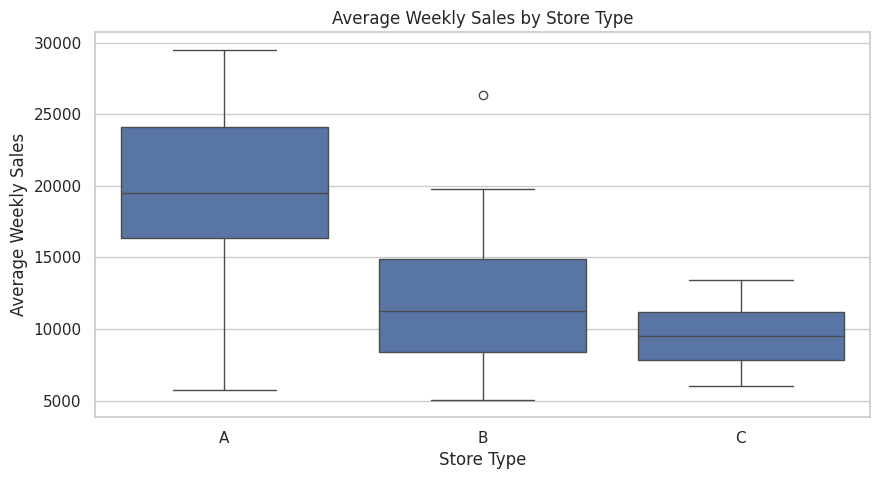

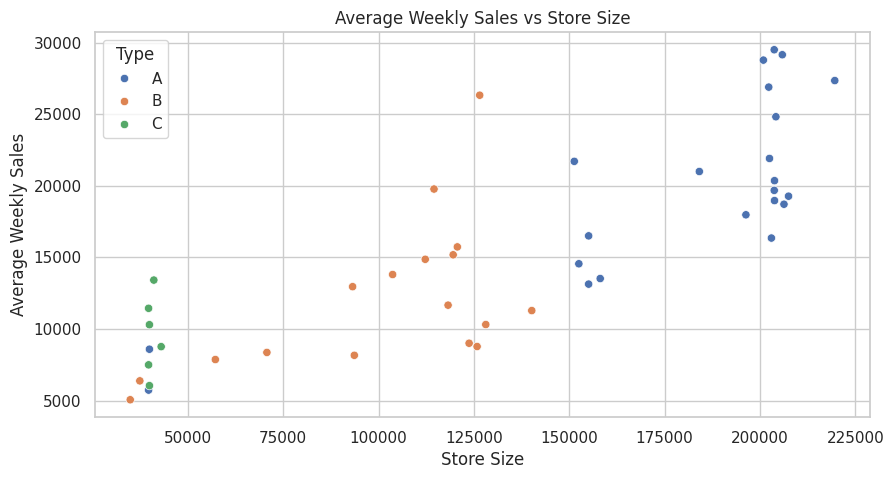

In [ ]:
# If original Type column existed, we can still use it via stores_df
# Use the original stores_df for a clean view
type_sales = full_df.groupby("Store").agg({
    "Weekly_Sales": "mean",
    "Size": "first"
}).reset_index()

# Merge with store type if needed
type_map = stores_df[["Store", "Type"]]
type_sales = type_sales.merge(type_map, on="Store", how="left")

sns.boxplot(x="Type", y="Weekly_Sales", data=type_sales)
plt.title("Average Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Weekly Sales")
plt.show()

sns.scatterplot(x="Size", y="Weekly_Sales", hue="Type", data=type_sales)
plt.title("Average Weekly Sales vs Store Size")
plt.xlabel("Store Size")
plt.ylabel("Average Weekly Sales")
plt.show()


### 6.4 Continuous Features and Correlation

I analyze how continuous external features relate to sales:

- Temperature
- Fuel_Price
- CPI
- Unemployment
- Size

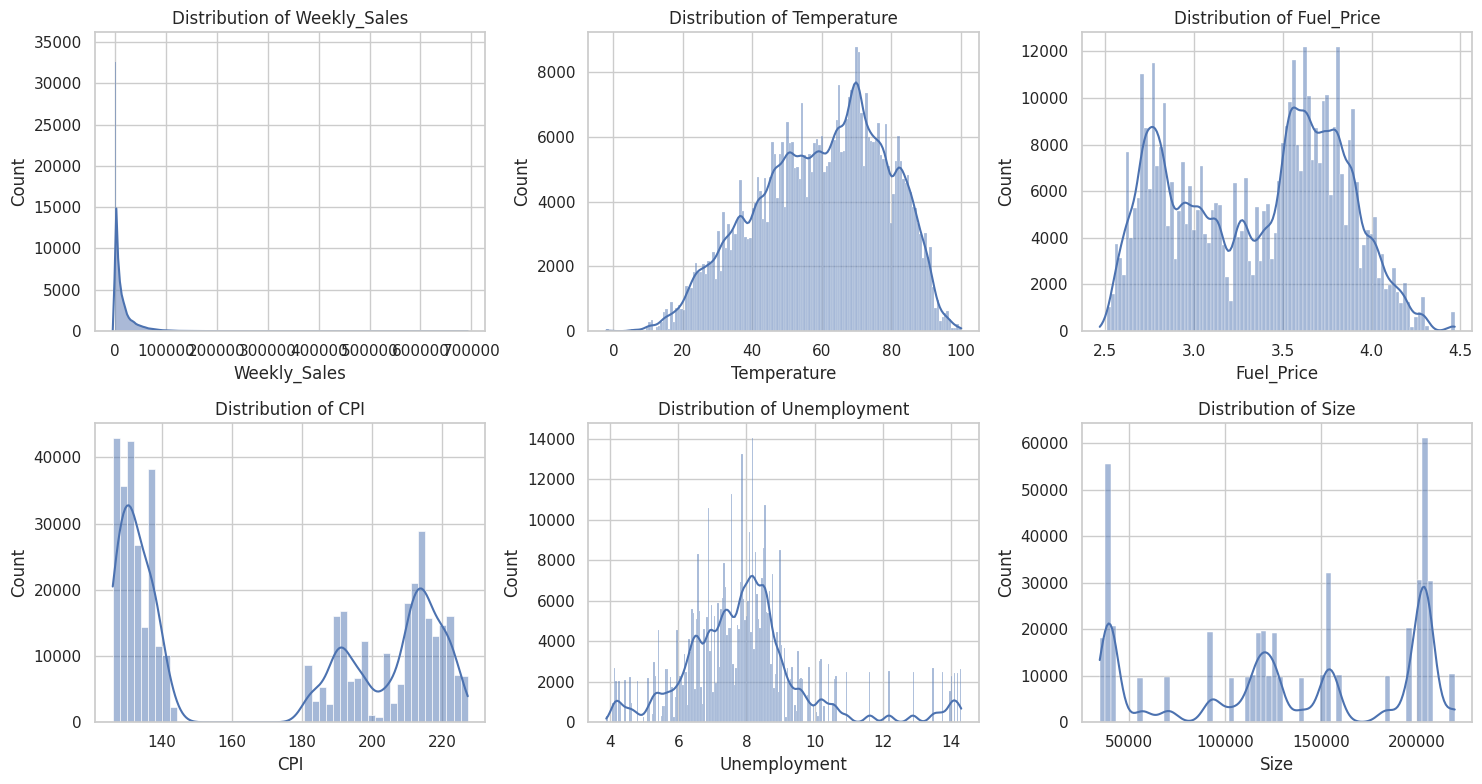

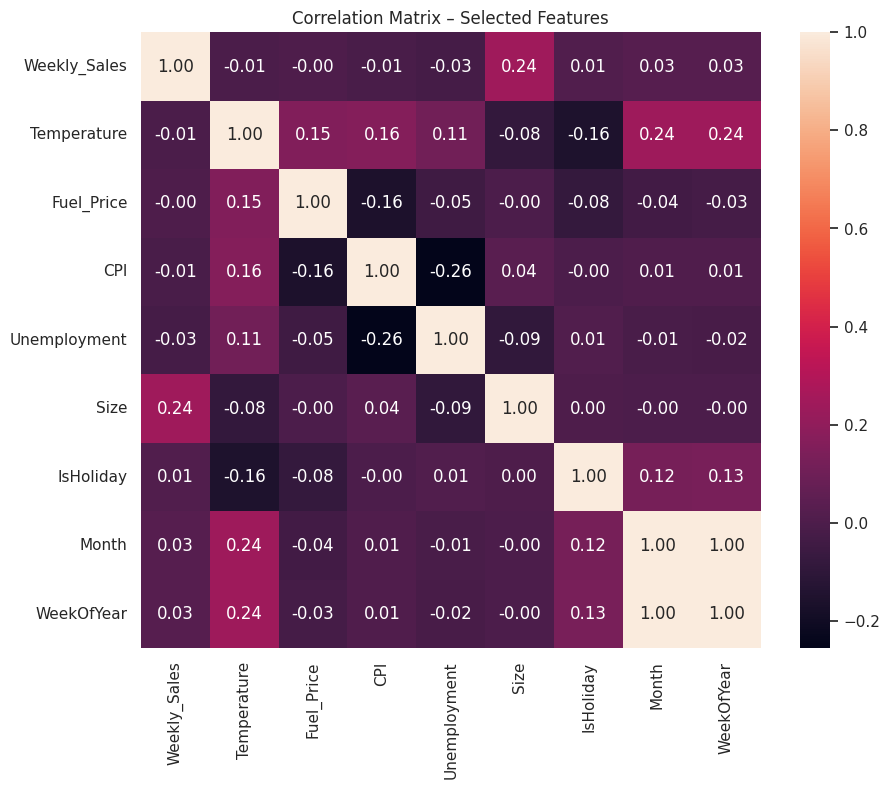

In [ ]:
num_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"]

# Histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(full_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Correlation matrix
corr = full_df[num_cols + ["IsHoliday", "Month", "WeekOfYear"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix – Selected Features")
plt.show()


### 6.5 EDA Summary

- `Weekly_Sales` is right-skewed with several large outliers, especially around holidays and promotions.
- Time series plots show clear seasonal patterns, with noticeable peaks around major holiday periods.
- Holiday weeks (`IsHoliday = 1`) have higher median sales than non-holiday weeks.
- Type A stores tend to have higher average weekly sales compared to Types B and C.
- Larger stores generally generate higher average weekly sales.
- Economic factors (CPI, Unemployment, Fuel_Price) show weaker direct correlation with sales but may interact with other variables.


In [12]:
# Save the prepared dataset for modeling notebooks
full_df.to_csv("walmart_prepared.csv", index=False)
print("Saved: walmart_prepared.csv", full_df.shape)


Saved: walmart_prepared.csv (241338, 20)
